---
author: Martin Proks
date: 15-01-2025
title: Bump v1.0 models to v1.0.1
---

This notebook merges the `v1.0` models with processed data uploaded to Zenodo.

> [!NOTE]
> Downstream analysis was done on `X_scVI` latent space, while the cell type
> prediction was done using `scANVI`.

In [74]:
import scvi
import pandas as pd
import scanpy as sc
from scipy import sparse


import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=UserWarning)


MOUSE_STAGE_COLORS = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'ICM': '#F6C445',
    'TE': '#5a94ce',
    'EPI': '#B46F9C',
    'PrE': '#D05B61'
}

MOUSE_CT_COLORS = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'E3.25-ICM': '#fadc8f',
    'E3.25-TE': '#5185b9',
    'E3.5-ICM': '#f8d06a',
    'E3.5-TE': '#7ba9d8',
    'E3.5-EPI': '#c38cb0',
    'E3.5-PrE': '#d97c81',
    'E3.75-ICM': '#F6C445',
    'E4.5-TE': '#5a94ce',
    'E4.5-EPI': '#B46F9C',
    'E4.5-PrE': '#D05B61'
}

HUMAN_STAGE_COLORS = {
    'Oocyte': '#000000',
    'Zygote': '#7985A5',
    'Pronucleus': '#555d73',
    'Prelineage': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    'Morula': '#657cbd',
    'Inner Cell Mass': '#F6C445',
    'Trophectoderm': '#5a94ce',
    'Epiblast': '#B46F9C',
    'Late epiblast': '#aa5c8f',
    'Primitive Endoderm': '#D05B61',
}

HUMAN_CT_COLORS = {
    'Prelineage': '#7985A5',
    '8C_3.0': '#028A46',
    'Morula_4.0': '#657cbd',
    'Inner Cell Mass': '#F6C445',
    'Primitive Endoderm': '#D05B61',
    'Epiblast_6.0': '#d6b2ca',
    'Epiblast_7.0': '#c38db1',
    'Late epiblast': '#aa5c8f',
    'Trophectoderm_5.0': '#cddff0',
    'Trophectoderm_6.0': '#bdd4eb',
    'Trophectoderm_7.0': '#acc9e6',
    'Trophectoderm_8.0': '#9cbfe2',
    'Trophectoderm_9.0': '#8bb4dd',
    'Trophectoderm_10.0': '#5a94ce',
}

## Mouse

In [ ]:
mouse = sc.read_h5ad("../results/03_mouse.processed.h5ad")
mouse

AnnData object with n_obs × n_vars = 2004 × 3000
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'stage', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'batch_og', '_scvi_batch', '_scvi_labels', 'leiden', 'dpt_pseudotime', 't', 'seg', 'edge', 't_sd', 'milestones', 'draw_graph_fa_density_ct'
    var: 'gene_ids', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ct_colors', 'ct_sizes', 'dendro_segments', 'diffmap_evals', 'draw_graph', 'draw_graph_fa_density_ct_params', 'experiment_colors', 'graph', 'hvg', 'iroot', 'leiden', 'log1p', 'milestones_colors', 'neighbors', 'paga', 'pca', 'ppt', 'pseudotime_list', 'seg_colors', 'stage_colors', 'timepoint_colors', 'tsne', 'umap'
    obsm: 'X_R', '

In [3]:
lvae = scvi.model.SCANVI.load('../results/02_mouse_integration/scanvi_ns_15/')
lvae

INFO     File ../results/02_mouse_integration/scanvi_ns_15/model.pt already downloaded                             


ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: False

In [4]:
lvae.adata.obs = mouse.obs.copy()
lvae.adata.var = mouse.var.copy()
lvae.adata.obsm = mouse.obsm.copy()

lvae.adata.uns = mouse.uns.copy()
lvae.adata.uns['log1p'] = {'base': None}
lvae.adata.uns['stage_colors'] = [MOUSE_STAGE_COLORS[x] for x in mouse.obs.stage.cat.categories]
lvae.adata.uns['ct_colors'] = [MOUSE_CT_COLORS[x] for x in mouse.obs.ct.cat.categories]

del lvae.adata.uns['dendro_segments']
del lvae.adata.uns['milestones_colors']
del lvae.adata.uns['ppt']
del lvae.adata.uns['pseudotime_list']
del lvae.adata.uns['seg_colors']

lvae.adata.layers['scVI_normalized'] = sparse.csr_matrix(lvae.adata.layers['scVI_normalized'])

In [5]:
sc.pp.neighbors(lvae.adata, use_rep='X_scVI')
sc.tl.diffmap(lvae.adata)
sc.tl.paga(lvae.adata, groups='ct')
sc.tl.draw_graph(lvae.adata, init_pos='paga', n_jobs=10)

2025-01-15 16:56:13.359472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
sc.tl.rank_genes_groups(lvae.adata, groupby='stage', key_added='degs_by_stage')
sc.tl.rank_genes_groups(lvae.adata, groupby='ct', key_added='degs_by_ct')

In [7]:
lvae.adata.uns['explainer'] = {
    'deep_scanvi': {
        'train_size': 0.9,
        'n_iterations': 10,
        'shap_values': pd.read_feather('/maps/projects/dan1/data/Brickman/github/preimplantation-portal/static/mouse_SHAP_v1.5.feather')\
                        .set_index('feature')\
                        .query('weight_mean > 0.01')
    }
}

In [10]:
lvae.save("../results/14_bump/mouse_scanvi_ns_15/", overwrite=True, save_anndata=True)

In [11]:
!du -h ../results/14_bump/mouse_scanvi_ns_15/adata.h5ad

217M	../results/14_bump/mouse_scanvi_ns_15/adata.h5ad


## Human

In [78]:
lvae = scvi.model.SCANVI.load("../results/02_human_integration/05_scanvi_ns15/")
lvae

INFO     File ../results/02_human_integration/05_scanvi_ns15/model.pt already downloaded                           


ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: False

In [79]:
human = sc.read_h5ad('/maps/projects/dan1/data/Brickman/github/preimplantation-portal/static/portal_human_v1.5.h5ad')

In [80]:
lvae.adata.obs = human.obs.copy()
lvae.adata.obs['stage'] = [x.split('_')[0] for x in lvae.adata.obs.ct]
lvae.adata.obs['stage'] = lvae.adata.obs['stage'].astype('category').cat.reorder_categories(['Prelineage', '8C', 'Morula', 'Trophectoderm', 'Inner Cell Mass', 'Epiblast', 'Late epiblast', 'Primitive Endoderm'])

lvae.adata.var = pd.DataFrame(human.var['index'].values, index=human.var.index, columns=['gene_ids']).copy()

lvae.adata.uns['stage_colors'] = [HUMAN_STAGE_COLORS[x] for x in lvae.adata.obs.stage.cat.categories]
lvae.adata.uns['ct_colors'] = [HUMAN_CT_COLORS[x] for x in lvae.adata.obs.ct.cat.categories]

del lvae.adata.layers['scANVI_normalized']
lvae.adata.layers['scVI_normalized'] = sparse.csr_matrix(lvae.adata.layers['scVI_normalized'])

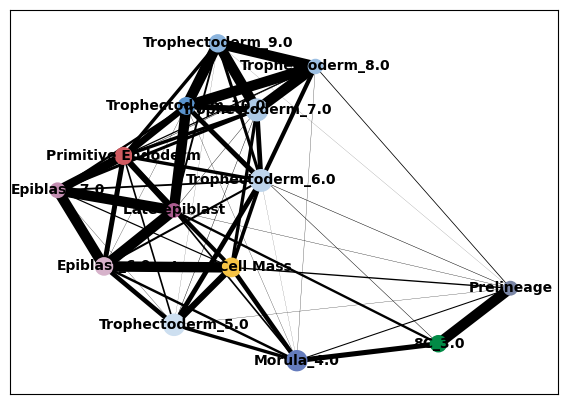

In [81]:
sc.pp.neighbors(lvae.adata, use_rep='X_scVI')
sc.tl.umap(lvae.adata)
sc.tl.diffmap(lvae.adata)
sc.tl.paga(lvae.adata, groups='ct')
sc.pl.paga(lvae.adata)
sc.tl.draw_graph(lvae.adata, init_pos='paga', n_jobs=10)

In [83]:
sc.tl.rank_genes_groups(lvae.adata, groupby='stage', key_added='degs_by_stage')
sc.tl.rank_genes_groups(lvae.adata, groupby='ct', key_added='degs_by_ct')

In [84]:
lvae.adata.uns['explainer'] = {
    'deep_scanvi': {
        'train_size': 0.9,
        'n_iterations': 10,
        'shap_values': pd.read_feather('/maps/projects/dan1/data/Brickman/github/preimplantation-portal/static/human_SHAP_v1.5.feather')\
                        .set_index('feature')\
                        .query('weight_mean > 0.01')
    }
}

In [85]:
lvae.save("../results/14_bump/human_scanvi_ns_15/", overwrite=True, save_anndata=True)

In [86]:
!du -h ../results/14_bump/human_scanvi_ns_15/adata.h5ad

323M	../results/14_bump/human_scanvi_ns_15/adata.h5ad
